<a href="https://colab.research.google.com/github/mshreeharsha/HuBMAP---Hacking-the-Human-Vasculature-FA-Major-Project/blob/main/initialDraft/HuBMAP_Hacking_the_Human_Vasculature_FA_Major_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Downloading the Dataset to Drive**

In [37]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
|cd /content/drive/My Drive/HuBMAP_Hacking_the_Human_Vasculature
￼
￼
[ ]
#LOSS FUNCTION#BCE_DICE@tf.keras.utils.register_keras_serializable()def DiceBCELoss(targets, inputs, smooth=1e-6, alpha = 0.8):    inputs = tf.reshape(inputs, (-1,))    targets = tf.reshape(targets, (-1,))    # Binary Cross Entropy    BCE = binary_crossentropy(targets, inputs)    # Dice Loss    intersection = tf.reduce_sum(targets * inputs)    dice_loss = 1 - (2 * intersection + smooth) / (tf.reduce_sum(targets) + tf.reduce_sum(inputs) + smooth)    # Combine Dice and BCE losses    Dice_BCE = (1-alpha)*BCE + alpha*dice_loss    return Dice_BCE


/content/drive/My Drive/HuBMAP_Hacking_the_Human_Vasculature


In [ ]:
from google.colab import files
files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!rm kaggle.json

In [ ]:
!kaggle competitions download -c hubmap-hacking-the-human-vasculature

In [ ]:
!cd ../..

In [ ]:
from zipfile import ZipFile
file_name="/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/hubmap-hacking-the-human-vasculature.zip"

with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

# **Dataset creation and preprosessing**

In [38]:
import cv2
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [39]:
#Paths to files
basePath = "/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature"
imagesFolder = basePath + "/train/"
labelsPath = basePath + "/polygons.jsonl"

In [40]:
#Function to Convert the JSONL file to a label dataset
def getLabelDataset(labelsPath):
  with open(labelsPath) as jsonFile:
            jsonList = list(jsonFile)

  labelsDataset = []
  for jsonStr in jsonList:
    result = json.loads(jsonStr)
    #result -> {id:"",annotations:[]}
    annotations = result['annotations']

    for ann in annotations:
        if ann["type"] != "blood_vessel":
            continue
        row = {
            "id": result["id"],
            "coordinates": ann["coordinates"],
        }
        labelsDataset.append(row)

  return pd.DataFrame(labelsDataset, columns=["id","coordinates"])

In [41]:
labels = getLabelDataset(labelsPath)
labels.head(5)

,id,coordinates
0,0006ff2aa7cd,"[[[283, 109], [282, 109], [281, 109], [280, 10..."
1,0006ff2aa7cd,"[[[104, 292], [103, 292], [102, 292], [101, 29..."
2,0006ff2aa7cd,"[[[505, 442], [504, 442], [503, 442], [502, 44..."
3,0006ff2aa7cd,"[[[375, 477], [374, 477], [373, 477], [372, 47..."
4,0006ff2aa7cd,"[[[368, 410], [367, 410], [366, 410], [365, 41..."


In [42]:
#Total No of Labels is 1633
currentLabelsSize = len(labels['id'].unique())
print(f"Number of ID-s removed, where 'blood_vessel' were missing: {1633-currentLabelsSize}")

Number of ID-s removed, where 'blood_vessel' were missing: 11


In [43]:
#Test-Train Split
uniqueIDs = labels['id'].unique()

trainIDs, testIDs = train_test_split(uniqueIDs, test_size=0.2, random_state=42)
trainLabels = labels[labels['id'].isin(trainIDs)]
testLabels = labels[labels['id'].isin(testIDs)]

In [44]:
print(len(trainLabels['id'].unique()))
print(len(testLabels['id'].unique()))

1297
325


In [45]:
#Generation of Mask from Coordinates
def generateMask(labels,imageID):
    mask = np.zeros((512, 512, 1), dtype=np.uint8)
    annotations = labels[labels['id'] == imageID]
    for _, row in annotations.iterrows():
        coordinates = np.array(row["coordinates"])
        mask = cv2.fillPoly(mask, [coordinates], 1)
    return mask

In [46]:
#Obtaining Image and its corresponding Mask
def getImageAndMask(labels,imageID):
  mask = generateMask(labels,imageID)
  imagePath = f"{imagesFolder}/{imageID}.tif"
  image = cv2.imread(imagePath, cv2.COLOR_BGR2RGB)
  return image,mask


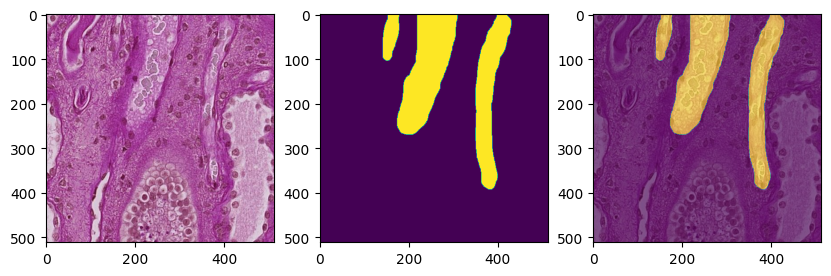

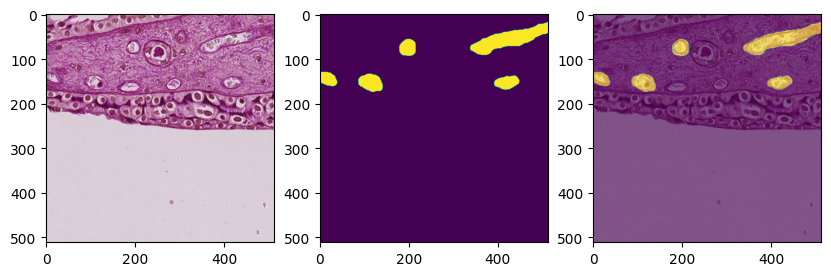

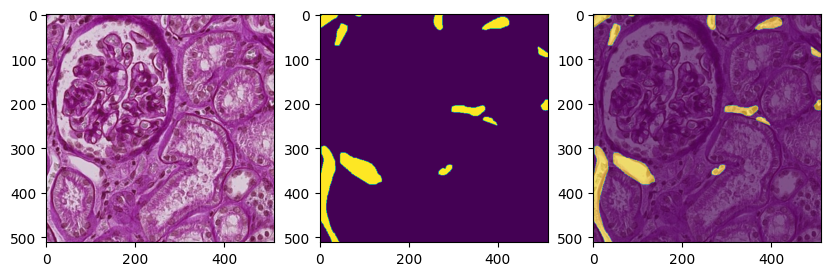

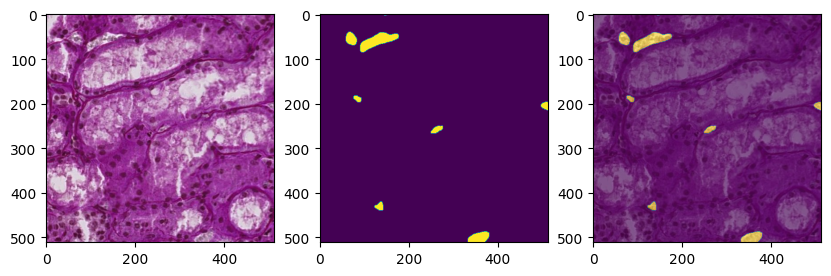

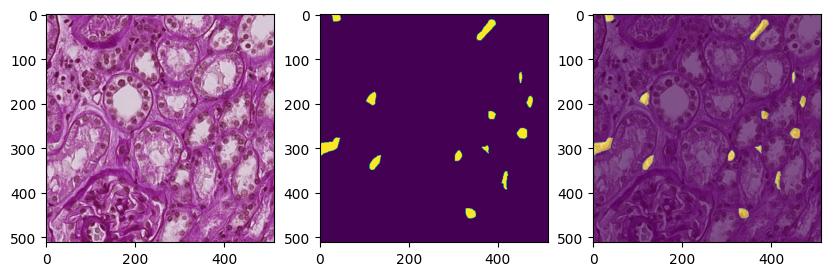

In [47]:
uniqueIDs = labels['id'].unique()
for index in range(10,15):
  imageID = uniqueIDs[index]
  image,mask = getImageAndMask(trainLabels,imageID)
  fig, axs = plt.subplots(1,3,figsize=(10,8))
  axs[0].imshow(image)
  axs[1].imshow(mask)
  axs[2].imshow(image)
  axs[2].imshow(mask, alpha=0.6)
  plt.show()

In [ ]:
#Takes a lot of time for dataset creation, that creating all pairs of image and mask
def createDataSet(labels,imageShape,maskShape):
    m = len(labels['id'].unique())
    i_h,i_w,i_c = imageShape
    m_h,m_w,m_c = maskShape
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)

    for index in range(len(labels['id'].unique())):
      print(index)
      image,mask = getImageAndMask(index,labels)
      X[index] = image
      y[index] = mask

    return X,y

trainImages,trainMasks = createDataSet(trainLabels,[512,512,3],[512,512,1])
testImages, testMasks = createDataSet(testLabels,[512,512,3],[512,512,1])

# **Applying UNET Model**

In [48]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import LeakyReLU
import keras.backend as K
import os

### **UNET Model Architecture**

In [49]:
def encoderBlock(inputs, noOfFilters=32, maxPooling=True):
    conv = Conv2D(noOfFilters,3,padding='same',kernel_initializer='HeNormal')(inputs)
    conv = LeakyReLU(alpha=0.1)(conv)
    conv = BatchNormalization()(conv, training=False)
    conv = Conv2D(noOfFilters,3,padding='same',kernel_initializer='HeNormal')(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
    conv = BatchNormalization()(conv, training=False)

    if maxPooling:
        nextLayer = MaxPooling2D(pool_size = (2,2))(conv)
    else:
        nextLayer = conv

    skipConnection = conv
    return nextLayer, skipConnection

In [50]:
def decoderBlock(prevLayerInput, skipLayerInput, noOfFilters=32, dropoutProb=0.3):
    up = Conv2DTranspose(noOfFilters,(3,3),strides=(2,2),padding='same')(prevLayerInput)

    merge = concatenate([up, skipLayerInput], axis=3)

    conv = Conv2D(noOfFilters,3,padding='same',kernel_initializer='HeNormal')(merge)
    conv = LeakyReLU(alpha=0.1)(conv)
    if dropoutProb > 0:
        conv = Dropout(dropoutProb)(conv)
    conv = BatchNormalization()(conv, training=False)
    conv = Conv2D(noOfFilters,3,padding='same',kernel_initializer='HeNormal')(conv)
    conv = LeakyReLU(alpha=0.1)(conv)
    conv = BatchNormalization()(conv, training=False)
    return conv

In [51]:
def UNETModel(inputSize=(512, 512, 3), noOfFilters=16, noOfClasses=1):
    inputs = Input(inputSize)

    encBlock1 = encoderBlock(inputs, noOfFilters, maxPooling=True)
    encBlock2 = encoderBlock(encBlock1[0],noOfFilters*2, maxPooling=True)
    encBlock3 = encoderBlock(encBlock2[0], noOfFilters*4, maxPooling=True)
    encBlock4 = encoderBlock(encBlock3[0], noOfFilters*8, maxPooling=True)
    encBlock5 = encoderBlock(encBlock4[0], noOfFilters*16, maxPooling=True)
    encBlock6 = encoderBlock(encBlock5[0], noOfFilters*32, maxPooling=False)

    decBlock7 = decoderBlock(encBlock6[0], encBlock5[1],  noOfFilters * 16, 0.3)
    decBlock8 = decoderBlock(decBlock7, encBlock4[1],  noOfFilters * 8, 0.3)
    decBlock9 = decoderBlock(decBlock8, encBlock3[1],  noOfFilters * 4, 0.3)
    decBlock10 = decoderBlock(decBlock9, encBlock2[1],  noOfFilters * 2, 0)
    decBlock11 = decoderBlock(decBlock10, encBlock1[1],  noOfFilters, 0)

    conv12 = Conv2D(noOfFilters,3,padding='same',kernel_initializer='he_normal')(decBlock11)
    conv12 = LeakyReLU(alpha=0.1)(conv12)
    conv13 = Conv2D(noOfClasses, 1, padding='same')(conv12)

    model = tf.keras.Model(inputs=inputs, outputs=conv13)

    return model

In [52]:
unet = UNETModel(inputSize=(512, 512, 3), noOfFilters=16, noOfClasses=1)
unet.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 512, 512, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 512, 512, 16)   │            448 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 512, 512, 16)   │              0 │ conv2d_24[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_22    │ (None, 512, 512, 16)   │             64 │ leaky_re_lu_23[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 512, 512, 16)   │          2,320 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 512, 512, 16)   │              0 │ conv2d_25[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_23    │ (None, 512, 512, 16)   │             64 │ leaky_re_lu_24[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_5           │ (None, 256, 256, 16)   │              0 │ batch_normalization_2… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 256, 256, 32)   │          4,640 │ max_pooling2d_5[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 256, 256, 32)   │              0 │ conv2d_26[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_24    │ (None, 256, 256, 32)   │            128 │ leaky_re_lu_25[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 256, 256, 32)   │          9,248 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 256, 256, 32)   │              0 │ conv2d_27[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_25    │ (None, 256, 256, 32)   │            128 │ leaky_re_lu_26[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_6      

 Total params: 8,662,913 (33.05 MB)

 Trainable params: 8,656,897 (33.02 MB)

 Non-trainable params: 6,016 (23.50 KB)

### **Training and Saving Model**

In [53]:
class config:
  batchSize = 8
  initLearningRate = 1e-3
  weightDecay = 1e-4
  epochs = 20

In [54]:
from tensorflow.keras.utils import Sequence
class ImageMaskDatasetGenerator(Sequence):
    def __init__(self, imageIDLabels, batchSize, imageMaskFunction, shuffle=True):
        self.imageIDLabels = imageIDLabels
        self.batchSize = batchSize
        self.imageMaskFunction = imageMaskFunction
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        # Number of batches per epoch
        return int(np.floor(len(self.imageIDLabels['id'].unique()) / self.batchSize))

    def __getitem__(self, index):
        # Generate a batch of image-mask pairs
        uniqueIDs = self.imageIDLabels['id'].unique()
        batchImagesIDs = uniqueIDs[index * self.batchSize:(index + 1) * self.batchSize]
        images, masks = [], []

        for img_id in batchImagesIDs:
            image, mask = self.imageMaskFunction(self.imageIDLabels,img_id)
            images.append(image)
            masks.append(mask)
            # fig, axs = plt.subplots(1,3,figsize=(10,8))
            # axs[0].imshow(image)
            # axs[0].set_title(f'Image ID: {img_id}')
            # axs[1].imshow(mask)
            # axs[2].imshow(image)
            # axs[2].imshow(mask, alpha=0.6)
            # plt.show()

        return np.array(images), np.array(masks)
    def on_epoch_end(self):
      if self.shuffle:
          self.imageIDLabels = self.imageIDLabels.sample(frac=1).reset_index(drop=True)

In [55]:
#LOSS FUNCTION
#BCE_DICE

@tf.keras.utils.register_keras_serializable()
def DiceBCELoss(targets, inputs, smooth=1e-6, alpha = 0.8):

    inputs = tf.reshape(inputs, (-1,))
    targets = tf.reshape(targets, (-1,))

    # Binary Cross Entropy
    BCE = binary_crossentropy(targets, inputs)

    # Dice Loss
    intersection = tf.reduce_sum(targets * inputs)
    dice_loss = 1 - (2 * intersection + smooth) / (tf.reduce_sum(targets) + tf.reduce_sum(inputs) + smooth)

    # Combine Dice and BCE losses
    Dice_BCE = (1-alpha)*BCE + alpha*dice_loss

    return Dice_BCE

In [56]:
@tf.keras.utils.register_keras_serializable()
def iouMetric(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > 0.5, tf.float32)  # Convert to binary

    intersection = tf.reduce_sum(y_true * y_pred)
    union = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection
    iou = (intersection + smooth) / (union + smooth)

    return iou

In [57]:
train_generator = ImageMaskDatasetGenerator(imageIDLabels=trainLabels,
                                            batchSize=config.batchSize, imageMaskFunction=getImageAndMask)

In [58]:
#Compiling Model

unet.compile(optimizer=AdamW(learning_rate=config.initLearningRate, weight_decay=config.weightDecay),
             loss=DiceBCELoss,
              metrics=['accuracy',iouMetric])

In [59]:
#creating Checkpoints for saving the Model weight

# checkpoint_path = basePath + "/training_1/cp-{epoch:04d}.keras"
checkpoint_path = basePath + "/training_1/cp.keras"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=False,
                                                 verbose=1)

In [ ]:
#Training
unet.fit(train_generator, epochs=config.epochs, callbacks=[cp_callback])

In [ ]:
os.listdir(checkpoint_dir)

In [ ]:
#Traditional Saving the model

unet.save('/content/drive/My Drive/HuBMAP_Hacking_the_Human_Vasculature/UNET.keras')
new_model = tf.keras.models.load_model('/content/drive/My Drive/HuBMAP_Hacking_the_Human_Vasculature/UNET.keras')

### **Model Prediction and Testing**

In [ ]:
class TestImageMaskGenerator(Sequence):
    def __init__(self, imageIDLabels, batchSize, imageMaskFunction):
        self.imageIDLabels = imageIDLabels
        self.batchSize = batchSize
        self.imageMaskFunction = imageMaskFunction
    def __len__(self):
        return int(np.floor(len(self.imageIDLabels['id'].unique()) / self.batchSize))

    def __getitem__(self, index):
        uniqueIDs = self.imageIDLabels['id'].unique()
        batch_ids = uniqueIDs[index * self.batchSize:(index + 1) * self.batchSize]
        images, masks = [], []

        for img_id in batch_ids:
            image, mask = self.imageMaskFunction(self.imageIDLabels,img_id)
            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)


In [ ]:
test_generator = TestImageMaskGenerator(imageIDLabels=testLabels,
                                        batchSize=config.batchSize, imageMaskFunction=getImageAndMask)

In [ ]:
model_path="/content/drive/MyDrive/HuBMAP_Hacking_the_Human_Vasculature/training_1/cp.keras"
model = tf.keras.models.load_model(model_path,custom_objects={'iou_metric': iouMetric})

In [ ]:
model.evaluate(test_generator)

In [ ]:
from matplotlib.colors import ListedColormap
Cmap = ListedColormap(['yellow', 'purple'])

def plotPredictions(image, originalMask, predictedMask):
    fig, axs = plt.subplots(1,3,figsize=(10,8))
    axs[0].imshow(image)
    axs[1].imshow(image)
    axs[1].imshow(originalMask,alpha=0.5)
    axs[2].imshow(image)
    axs[2].imshow(predictedMask,alpha=0.5, cmap=Cmap)
    plt.show()

images, originalMasks = test_generator[0]

predictedMasks = model.predict(images)
predictedMasks = (predictedMasks > 0.5).astype(np.uint8)

for i in range(len(images)):
    image = images[i]
    originalMask = originalMasks[i]
    predictedMask = predictedMasks[i]

    # Plot original image, original mask, and predicted mask
    plotPredictions(image, originalMask, predictedMask)
